In [44]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [45]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
from collections import defaultdict
from itertools import combinations
import math
import time
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
from collections import defaultdict
from itertools import combinations
import math
import time
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from numpy import *
from math import *
from random import *

In [46]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-qbraid-jobs" # the name of the bucket
my_prefix = "mazhandufarai-40gmail-2ecom" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)
# session and device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)


In [47]:
# Put the following lines in the terminal to install ipywidgets:
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension

# Put the following lines in the terminal to install qiskit and mqt.ddsim:
# pip install qiskit
# pip install mqt.ddsim

# Imports for the GUI of the program

import ipywidgets as widgets
from IPython.display import display

# Defining the functions of the program

# Function that adds dropdowns for the equipment required for each patient

def addPatients(addButtonClicked):
    
    equipmentDropdowns = []
    equipmentOptions = [('Basic Life Support (BLS)', 1), 
                        ('Basic Life Support (BLS) Emergency', 2), 
                        ('Advanced Life Support (ALS), Level One', 3), 
                        ('Advanced Life Support (ALS), Level One, Emergency', 4), 
                        ('Advanced Life Support (ALS), Level Two', 5), 
                        ('Specialty Care Transport', 6), ('Paramedic Intercept', 7)]
    
    for i in range(patientsSlider.value):
        equipmentDropdowns.append(widgets.Dropdown(description='Equipment:', options=equipmentOptions))
    
    patientsAccordion.children = equipmentDropdowns
    
    for i in range(patientsSlider.value):
        patientsAccordion.set_title(i, 'Patient ' + str(i+1))
    
    display(patientsAccordion)

# Function that finds the best possible hosppital for each patient

def findHospital():
    print('Hello world')
    
    
# Designing the GUI of the program

locationText = widgets.Text(description='Location:', placeholder='Enter your current location')
display(locationText)

hospitalsSlider = widgets.IntSlider(description='Hospitals:', min=0, max=100, step=1)
display(hospitalsSlider)

patientsSlider = widgets.IntSlider(description='Patients:', min=0, max=100, step=1)
display(patientsSlider)

addButton = widgets.Button(description='Add Patients', button_style='Info')
addButton.on_click(addPatients) # Calling function to add patients
display(addButton)

patientsAccordion = widgets.Accordion(children=[])
display(patientsAccordion)

searchButton = widgets.Button(description='Search Hospital', button_style='Info')
# searchButton.on_click() # Calling function to search patients
display(searchButton)

progressBar = widgets.IntProgress(min=0, max=3, value=2, step=1, bar_style='Info')
display(progressBar)

hospitalDestination = widgets.Text(description='Hospital:', disabled=True)
display(hospitalDestination)


Text(value='', description='Location:', placeholder='Enter your current location')

IntSlider(value=0, description='Hospitals:')

IntSlider(value=0, description='Patients:')

Button(button_style='info', description='Add Patients', style=ButtonStyle())

Accordion()

Button(button_style='info', description='Search Hospital', style=ButtonStyle())

IntProgress(value=2, bar_style='info', max=3)

Text(value='', description='Hospital:', disabled=True)

In [48]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=400)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [49]:
# helper function to plot graph
def get_colored_graph(graph, pos, colors):
    """
    plot colored graph for given solution
    """
    
    # positions for all nodes
    # pos = nx.spring_layout(graph)
    
    colorlist = ['#377eb8', '#e41a1c']
    nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png

Graph on 200 nodes created with 19900 out of 19900.0 possible edges.


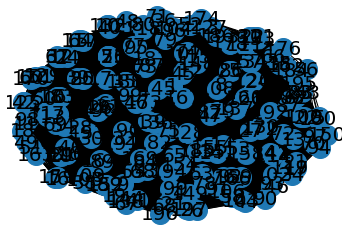

In [54]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Input values
row = 10  #Number of hospitals
col = 20  #Number of patients

# ------- Set tunable parameters -------
num_reads = 1000
gamma = 80

# ------- 8 up our graph -------
vertices = row*col
G = nx.gnp_random_graph(vertices, 1)

print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
                                                                           len(G.edges), 
                                                                           len(G.nodes) * (len(G.nodes)-1) / 2))
# for i in range len(G.edges):
#     for j in range len(i,G.edges):
#         if i==j:
#             Q[(u,v)]=i
#         elif:
#             x=i\\4
#             y=j\\4
            
            
# ------- Plot our graph -------
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Fill in Q matrix
# for u, v in G.edges:
#     Q[(u,u)] += 1
#     Q[(v,v)] += 1
#     Q[(u,v)] += -2

# alpha = [1.99,-0.01,-0.01,1.99]
# alpha = [3,5,1,7,3,2]
# alpha = [-0.01,1.99,-0.01,3.99,-0.01,0.99]
epsilon = 0.01
# Minimum between alpha[0] and alpha[2]-epsilon
# Minimum between alpha[1] and alpha[2]-epsilon
# bh1 = [1,2]  #importance from Edgar
bh2 = [200,100,50]



alpha=[] #alpha = D - lambda*E
D=[] #distance between each patient and each hospital (normalized)
lamb=[] #Lambda is the weight between the distance and the equipment parameters
E=[] #Equipement parameter that includes the availability of the hospital

bh1=[] #constraints that prevent all the patients from going to the same hospital
bh2=[] #constraints that prevent a patient from being assigned to multiple hospitals at once

for i in range(row*col):        #Generate random lambda (weight) values between 0 and 1
    lamb.append(random())  
for i in range(row*col):        #Generate random distances (normalized)
    D.append(randint(1,10))
for i in range(row*col):        #Generate random equipment values (normalized)
    E.append(randint(1,10))

#Combine these values to obtaine alpha
num=0 
while num<row*col:
    alpha.append(D[num]-lamb[num]*E[num])
    num+=1
# print("alpha",alpha)
for i in range(row):
    bh1.append(randint(1,10))
# print("bh1",bh1)
for i in range(col):
    bh2.append(randint(100,200))
# print("bh2",bh2)

# Fill the Q matrix where the alpha values are on the diagonal and the beta values are the rest
Q = [[0 for i in range(col*row)] for j in range(row*col)]
for i in range (row*col):
    for j in range (col*row):
        if i==j:                     #alpha on the diagonal
            Q[i][j] = alpha[i]
        else:                        #bh1 for values on the row (same hospital)
            a=(i+1)//(col+1)
            b=(j+1)//(col+1)
            if a==b:
                Q[i][j]=bh1[a]
            else:                    #bh2 for values on the same column (same patient)
                a=(i+1)%col
                b=(j+1)%col
                if a==b:
                    Q[i][j]=bh2[a]
                else:
                    Q[i][j]=0
# print(Q)

In [ ]:
# ------- Run our QUBO on the QPU -------

# Set chain strength
chain_strength = gamma*len(G.nodes)

# Run the QUBO on Braket
start = time.time()

# sampler = BraketDWaveSampler(s3_folder,"arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
sampler = BraketDWaveSampler(s3_folder,"arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chain_strength, num_reads=num_reads)

# See if the best solution found is feasible, and if so print the number of cut edges.
# sample = response.record.sample[0] #print the first sample with the best cost
sample = response.record.sample  #print all the samples
print(sample)

# print execution time
end = time.time()
print('Code execution time [sec]:', end - start)


In [ ]:
if type(sample) != list:
    sample=sample.tolist()

for res in list(sample): #choose the solution that 
    m = []
    while res != []:
        m.append(res[:col])
        res = res[col:]
    m=transpose(m)
    
    k=0
    comp=True
    while k<len(m) and comp==True:
        if 1 not in m[k]:
            comp=False
        k+=1
    # print(m)
    if comp==True:
        m=transpose(m)
        print(m)
        break


for coll in range(len(m[0])):
    x = 0
    for roww in range(len(m)):
        if m[roww][coll] == 1 and x == 0:
            print("Patient ", coll+1, " to hospital ", roww+1)
            x = 1